In [179]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from scipy.stats import norm
from sklearn.metrics import r2_score

In [180]:
# Laste poll-of-polls data
df = pd.read_csv("../data/v2_data_august.csv", sep=",")

In [181]:
df

,Mnd,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
0,1/31/2008,29.3,17.2,23.9,7.4,6.1,6.4,6.5,0.0,1.3,...,NaN,NaN,NaN,NaN,2.6,NaN,NaN,5.25,NaN,NaN
1,2/29/2008,29.0,17.3,25.2,6.7,5.9,6.3,6.6,0.0,1.3,...,NaN,NaN,NaN,NaN,2.6,NaN,NaN,5.25,NaN,NaN
2,3/31/2008,28.7,18.1,25.2,7.0,5.6,6.1,6.3,0.0,1.1,...,0.0,NaN,0.0,NaN,2.6,0.000,NaN,5.25,0.000000,NaN
3,4/30/2008,29.0,16.9,25.4,6.5,5.5,7.0,6.8,0.0,1.2,...,0.0,NaN,0.0,NaN,2.7,0.033,NaN,5.31,0.020000,NaN
4,5/31/2008,28.9,17.8,25.9,6.7,5.7,6.2,6.2,0.0,1.4,...,0.0,NaN,0.0,NaN,2.8,0.067,NaN,5.50,0.083333,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,5/31/2025,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
209,6/30/2025,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
210,7/31/2025,27.7,14.8,21.5,8.2,6.3,3.2,4.7,3.5,5.9,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.25,-0.083333,-0.041667
211,8/31/2025,27.0,15.3,21.4,6.3,6.2,4.6,4.4,4.1,6.2,...,0.0,0.0,0.0,0.0,4.0,0.000,0.000000,4.25,-0.083333,-0.041667


In [182]:
ex_future=df[df['Ap'].isna()][['Mnd',
       'Ap_skandale_lag6', 'Hoyre_skandale_lag6', 'Frp_skandale_lag6',
       'SV_skandale_lag6', 'SP_skandale_lag6', 'KrF_skandale_lag6',
        'Rodt_skandale_lag6',
        'Ap_reg_lag6',
        'Hoyre_reg_lag6', 
        #'Frp_reg_lag6','SV_reg_lag6', 
        #'SP_reg_lag6','KrF_reg_lag6',
        #'Venstre_reg_lag6', 
       'ledighet', 'ledig_trend3', 'ledig_trend6', 'styringsrente',
       'styringsrente_trend3', 'styringsrente_trend6']]

In [183]:
ex_future
ex_future["Mnd"] = pd.to_datetime(df["Mnd"])
ex_future.set_index("Mnd", inplace=True)

In [184]:
df.dropna(inplace=True)

In [185]:
df

,Mnd,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
5,6/30/2008,26.0,17.6,28.9,6.9,5.3,6.1,5.9,0.0,1.8,...,0.0,0.0,0.0,0.0,2.9,0.067,0.050000,5.54,0.076667,0.048333
6,7/31/2008,26.9,17.2,30.2,6.6,4.7,6.1,5.4,0.0,1.9,...,0.0,0.0,0.0,0.0,2.9,0.033,0.050000,5.75,0.083333,0.083333
7,8/31/2008,26.6,16.2,30.9,6.7,5.2,5.5,6.0,0.0,1.7,...,0.0,0.0,0.0,0.0,3.0,0.033,0.066667,5.75,0.070000,0.083333
8,9/30/2008,28.9,15.2,29.9,6.3,5.0,5.7,5.9,0.0,1.5,...,0.0,0.0,0.0,0.0,3.1,0.067,0.066667,5.75,0.000000,0.073333
9,10/31/2008,30.6,16.1,26.7,7.3,5.3,5.6,5.5,0.0,1.2,...,0.0,0.0,0.0,0.0,3.1,0.033,0.050000,5.45,-0.100000,-0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,4/30/2025,28.1,19.8,20.0,6.3,6.7,3.3,3.9,3.1,4.8,...,0.0,0.0,0.0,0.0,4.0,-0.033,-0.016667,4.50,0.000000,0.000000
208,5/31/2025,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
209,6/30/2025,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
210,7/31/2025,27.7,14.8,21.5,8.2,6.3,3.2,4.7,3.5,5.9,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.25,-0.083333,-0.041667


In [186]:
# Convert to datetime and set the date to the end of the month
df["Mnd"] = pd.to_datetime(df["Mnd"])

In [187]:
# Sort values and set index
df = df.sort_values("Mnd")
df.set_index("Mnd", inplace=True)

In [188]:
df

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
Mnd,,,,,,,,,,,,,,,,,,,,,
2008-06-30,26.0,17.6,28.9,6.9,5.3,6.1,5.9,0.0,1.8,0.0,...,0.0,0.0,0.0,0.0,2.9,0.067,0.050000,5.54,0.076667,0.048333
2008-07-31,26.9,17.2,30.2,6.6,4.7,6.1,5.4,0.0,1.9,0.0,...,0.0,0.0,0.0,0.0,2.9,0.033,0.050000,5.75,0.083333,0.083333
2008-08-31,26.6,16.2,30.9,6.7,5.2,5.5,6.0,0.0,1.7,0.0,...,0.0,0.0,0.0,0.0,3.0,0.033,0.066667,5.75,0.070000,0.083333
2008-09-30,28.9,15.2,29.9,6.3,5.0,5.7,5.9,0.0,1.5,0.0,...,0.0,0.0,0.0,0.0,3.1,0.067,0.066667,5.75,0.000000,0.073333
2008-10-31,30.6,16.1,26.7,7.3,5.3,5.6,5.5,0.0,1.2,0.0,...,0.0,0.0,0.0,0.0,3.1,0.033,0.050000,5.45,-0.100000,-0.008333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30,28.1,19.8,20.0,6.3,6.7,3.3,3.9,3.1,4.8,3.9,...,0.0,0.0,0.0,0.0,4.0,-0.033,-0.016667,4.50,0.000000,0.000000
2025-05-31,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3,3.8,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
2025-06-30,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2,4.5,...,0.0,0.0,0.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000


In [189]:
df_en=df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
df_en = df_en.diff().dropna()  # Difference to make stationary
df_orig=df

In [190]:
df_ex=df[[
       'Ap_skandale_lag6', 'Hoyre_skandale_lag6', 'Frp_skandale_lag6',
       'SV_skandale_lag6', 'SP_skandale_lag6', 'KrF_skandale_lag6',
       #'Venstre_skandale_lag6', 
        #'MDG_skandale_lag6', 
       'Rodt_skandale_lag6',
       #'Andre_skandale_lag6', 
       # 'Ap_reg', 'Hoyre_reg', 'Frp_reg', 'SV_reg',
       #'SP_reg', 'KrF_reg', 'Venstre_reg', 'MDG_reg', 'Rodt_reg', 'Andre_reg',
       #'Ap_reg_lag3', 
       'Ap_reg_lag6',
        'Hoyre_reg_lag6', 
       # 'Frp_reg_lag6','SV_reg_lag6', 
       # 'SP_reg_lag6','KrF_reg_lag6',
       # 'Venstre_reg_lag6', 
        #'MDG_reg_lag6',
        #'Rodt_reg_lag6', 
        #'Andre_reg_lag6',
       'ledighet', 'ledig_trend3', 'ledig_trend6', 'styringsrente',
       'styringsrente_trend3', 'styringsrente_trend6']].iloc[1:]

In [191]:
df_ex

,Ap_skandale_lag6,Hoyre_skandale_lag6,Frp_skandale_lag6,SV_skandale_lag6,SP_skandale_lag6,KrF_skandale_lag6,Rodt_skandale_lag6,Ap_reg_lag6,Hoyre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
Mnd,,,,,,,,,,,,,,,
2008-07-31,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,2.9,0.033,0.050000,5.75,0.083333,0.083333
2008-08-31,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.0,0.033,0.066667,5.75,0.070000,0.083333
2008-09-30,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.1,0.067,0.066667,5.75,0.000000,0.073333
2008-10-31,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.1,0.033,0.050000,5.45,-0.100000,-0.008333
2008-11-30,1.0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,3.1,0.000,0.033333,4.75,-0.333333,-0.131667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,-0.033,-0.016667,4.50,0.000000,0.000000
2025-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000
2025-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,0.000,-0.016667,4.50,0.000000,0.000000


In [192]:
#model = VARMAX(endog=df_en, exog=df_ex, order=(6,0), trend='c')
#model_fitted = model.fit(disp=False)

#print(model_fitted.summary())

In [193]:
model = VAR(endog=df_en, exog=df_ex)
#model = VAR(endog=df_en)

C:\Users\jens.nilsen\python\WPy64-31230\python-3.12.3.amd64\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


In [194]:
model_fitted = model.fit(maxlags=2,method = 'ols', trend='n', verbose=True)
print(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 27, Aug, 2025
Time:                     12:48:22
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                   -6.94340
Nobs:                     204.000    HQIC:                  -10.3334
Log likelihood:          -1255.74    FPE:                3.36537e-06
AIC:                     -12.6362    Det(Omega_mle):     6.90804e-07
--------------------------------------------------------------------
Results for equation Ap
                          coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------------
Ap_skandale_lag6            -0.132655         0.231241           -0.574           0.566
Hoyre_skandale_lag6          0.019609         0.244994            0.080           0.936
Frp_skandale_lag6            0.1397

In [195]:
# Compute R² for each party
r2_scores = {}
for party in ['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']:
    r2_scores[party] = r2_score(df_en[party].iloc[model_fitted.k_ar:], model_fitted.fittedvalues[party])

# Print R² values
for party, r2 in r2_scores.items():
    print(f"R² for {party}: {r2:.4f}")

R² for Ap: 0.2138
R² for Hoyre: 0.2631
R² for Frp: 0.2155
R² for SV: 0.2896
R² for SP: 0.1675
R² for KrF: 0.3888
R² for Venstre: 0.2869
R² for MDG: 0.2241
R² for Rodt: 0.3017
R² for Andre: 0.2378


In [196]:
# Check if the VAR model is stable (roots inside the unit circle)
print("Is the VAR model stable?", model_fitted.is_stable())

Is the VAR model stable? True


In [197]:
all_fitted= model_fitted.fittedvalues

In [198]:
all_fitted

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre
Mnd,,,,,,,,,,
2008-09-30,0.877098,-0.869029,-0.522289,0.173048,-0.162482,0.461136,-0.196937,0.084085,-0.050112,-0.008064
2008-10-31,0.552215,-0.327948,-0.222299,0.372731,-0.051753,0.096035,-0.033764,0.023435,-0.285988,-0.115956
2008-11-30,0.994352,0.249355,-0.688277,-0.199278,-0.450918,0.300727,0.130545,-0.123646,-0.346491,-0.066814
2008-12-31,0.305299,0.820746,0.114154,-0.024676,-0.269875,-0.448691,-0.265563,-0.069104,-0.240902,-0.383774
2009-01-31,2.873342,-1.011669,-1.129128,-0.069577,-0.507782,-0.022249,0.075605,-0.051859,-0.308705,-0.050054
...,...,...,...,...,...,...,...,...,...,...
2025-04-30,-0.273093,0.099979,-1.080263,-0.084973,0.473620,0.455393,0.089671,0.097107,0.185838,0.023851
2025-05-31,0.387423,-1.197966,0.630520,0.415745,-0.068632,-0.020115,0.134087,-0.177751,0.200480,-0.171709
2025-06-30,1.213722,-1.138053,0.492706,-0.639354,-0.132276,0.071883,-0.174825,0.310341,-0.138566,0.030709


In [199]:
steps = 1  # Number of steps to forecast
alpha = 0.1

forecast, lower, upper = model_fitted.forecast_interval(df_en.values[-model_fitted.k_ar:],  exog_future=ex_future, steps=steps, alpha=alpha)


In [200]:
forecast

array([[-0.15273886, -0.41647782,  0.37595559,  0.69507921,  0.63976674,
        -0.91758489,  0.05656798, -0.07432765,  0.35651786, -0.54726028]])

In [201]:
forecast_dates = pd.date_range(start="2025-09-30", periods=steps, freq='ME')

last_actual_value = df_orig.iloc[-1]  # Last known actual data point

forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=df_en.columns)
forecast_lower_df=pd.DataFrame(lower, index=forecast_dates, columns=df_en.columns)
forecast_upper_df=pd.DataFrame(upper, index=forecast_dates, columns=df_en.columns)

forecast_df = forecast_df.cumsum() + last_actual_value
forecast_lower_df = forecast_lower_df.cumsum() + last_actual_value
forecast_upper_df = forecast_upper_df.cumsum() + last_actual_value

In [202]:
# Get forecast covariance in differenced scale
forecast_cov = model_fitted.forecast_cov(steps=steps)

# Cumulative sum of covariance matrices to restore original scale
for t in range(steps):
    forecast_cov[t] = np.sum(forecast_cov[:t+1], axis=0)

# Convert to DataFrames for readability
forecast_cov_df = {t: pd.DataFrame(forecast_cov[t], index=df_en.columns, columns=df_en.columns)
                            for t in range(steps)}

In [203]:
df_en=df_orig

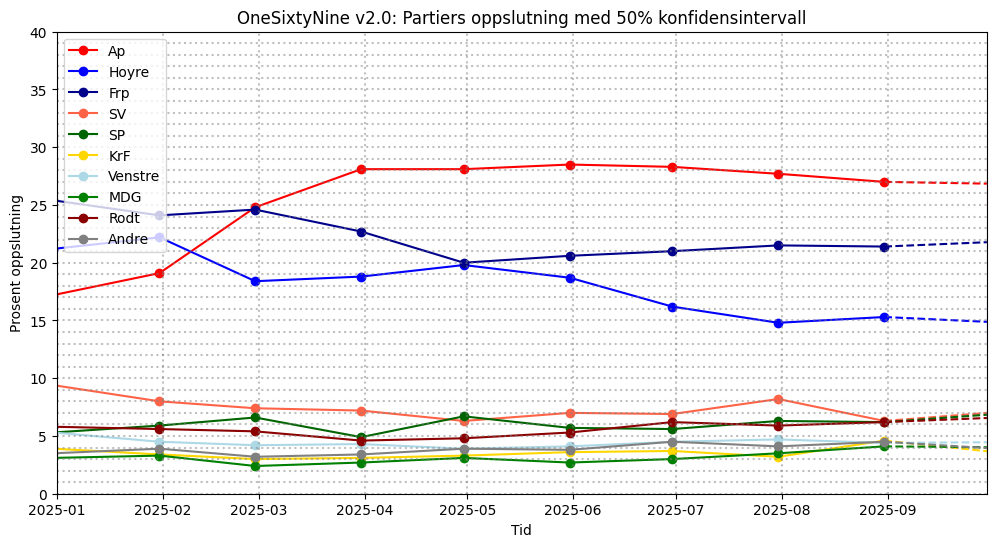

In [204]:
# Define a color map for consistency
colors = {
    'Ap': '#FF0000',        # Red
    'Hoyre': '#0000FF',     # Blue
    'Frp': '#00008B',       # Dark Blue
    'SV': '#FF6347',        # Light Red (Tomato)
    'SP': '#006400',        # Dark Green
    'KrF': '#FFD700',       # Yellow (Gold)
    'Venstre': '#ADD8E6',   # Light Blue
    'MDG': '#008000',       # Green
    'Rodt': '#8B0000',      # Dark Red
    'Andre': '#808080'      # Gray
}

plt.figure(figsize=(12, 6))

for party in colors.keys():  # Iterate over defined parties
    color = colors[party]  

    # Plot actual data
    plt.plot(df_en.index, df_en[party], marker="o", color=color, label=f"{party}")

    # Plot forecast 
    plt.plot(forecast_df.index, forecast_df[party], linestyle="dashed", color=color)

    last_actual_date = df_en.index[-1]
    first_forecast_date = forecast_df.index[0]
    last_actual_value = df_en[party].iloc[-1]
    first_forecast_value = forecast_df[party].iloc[0]

    plt.plot([last_actual_date, first_forecast_date], [last_actual_value, first_forecast_value], color=color, linestyle="dashed")
    
    # Plot confidence interval (original scale)
    plt.fill_between(forecast_df.index, 
                     forecast_lower_df[party], 
                     forecast_upper_df[party], 
                     color=color, alpha=0.2)


dates = pd.date_range(start="2023-01-01", end="2025-09-30", freq="MS") 
for date in dates:
    plt.axvline(date, color="gray", linestyle="dotted", alpha=0.5)

# Add horizontal grid lines every 5%
for percent in range(0, 45, 1):
    plt.axhline(percent, color="gray", linestyle="dotted", alpha=0.5)

plt.xlim(np.datetime64("2025-01-01"), np.datetime64("2025-09-30"))  # Manually set max date to Sept 2025
plt.ylim(0,40)  # Manually set max date to Sept 2025
plt.xlabel("Tid")
plt.ylabel("Prosent oppslutning")
plt.title("OneSixtyNine v2.0: Partiers oppslutning med 50% konfidensintervall")
plt.legend(loc="upper left")
plt.show()

In [205]:
forecast_df=forecast_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
#forecast_df=(forecast_df.T / forecast_df.sum(axis=1) * 100).T
forecast_lower_df=forecast_lower_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]
forecast_upper_df=forecast_upper_df[['Ap', 'Hoyre', 'Frp', 'SV', 'SP', 'KrF', 'Venstre', 'MDG', 'Rodt','Andre']]

In [206]:
###finn estimat for september
date_to_extract = "2025-09-30"

# Extract the row for the given date from each dataframe
estimate_row = forecast_df.loc[date_to_extract]
lower_row = forecast_lower_df.loc[date_to_extract]
upper_row = forecast_upper_df.loc[date_to_extract]

# Combine into a new DataFrame
result_df = pd.DataFrame({
    "Party": estimate_row.index,
    "Estimate": estimate_row.values,
    "Lower": lower_row.values,
    "Upper": upper_row.values
})

# Display the final structured DataFrame
result_df

,Party,Estimate,Lower,Upper
0,Ap,26.847261,24.480663,29.213860
1,Hoyre,14.883522,12.901455,16.865589
2,Frp,21.775956,19.917323,23.634588
3,SV,6.995079,6.248586,7.741573
4,SP,6.839767,5.352938,8.326596
5,KrF,3.682415,3.114284,4.250546
6,Venstre,4.456568,3.800305,5.112831
7,MDG,4.025672,3.467198,4.584146
8,Rodt,6.556518,5.836705,7.276330
9,Andre,3.952740,3.322909,4.582570


In [207]:
# Multivariate MC!
n_sim = 1000000
# Extract mean estimates (yhat) and covariance matrix
yhat_vector = result_df["Estimate"].values  # Mean estimates for all parties
yhat_vector = df_orig.iloc[-1][['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt','Andre']].values
cov_matrix = forecast_cov[-1]  # Covariance matrix at final step (latest forecast)
#cov_matrix = df_orig[['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt','Andre']].cov()#.to_numpy()
#cov_matrix=cov_matrix_df.to_numpy()

# Convert to NumPy array
#W = cov_matrix.to_numpy()

# Generate correlated samples
samples = np.random.multivariate_normal(yhat_vector, cov_matrix, size=n_sim)
samples = np.maximum(samples, 1e-6) ##must be above 0
#samples = (samples.T / samples.sum(axis=1) * 100).T

# Create a DataFrame with sampled values
sampled_df = pd.DataFrame(samples, columns=result_df["Party"])

# Compute vote totals for each simulation
red_green_votes = sampled_df[["Ap", "SV", "SP", "Rodt", "MDG"]].sum(axis=1)# /sampled_df.sum(axis=1)
blue_votes = sampled_df[["Hoyre", "Frp", "KrF", "Venstre"]].sum(axis=1)# /sampled_df.sum(axis=1)

# Probability that red-green block wins
prob_red_green_wins = np.mean(red_green_votes > blue_votes)

print(f"Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: {prob_red_green_wins:.4f}")


Sannsyn for at Ap+SV+Sp+R+MDG > H+FrP+KrF+V: 0.9247


In [208]:
cov_matrix

array([[ 2.07011564e+00, -6.20344345e-01, -5.96725817e-01,
        -1.45160126e-01, -3.16536531e-01, -4.33263533e-02,
        -1.30009562e-01, -6.95608390e-02, -1.59812425e-01,
         1.96979408e-02],
       [-6.20344345e-01,  1.45205153e+00, -3.44390902e-01,
        -5.74416141e-02, -2.38699468e-01, -6.14532589e-02,
        -1.06844044e-02, -7.05659393e-02, -2.59862965e-02,
        -1.70998857e-02],
       [-5.96725817e-01, -3.44390902e-01,  1.27682836e+00,
        -2.53369510e-02, -1.19467059e-01, -1.58985656e-02,
        -5.54854047e-02,  9.29363172e-03, -3.87719395e-02,
        -8.22744307e-02],
       [-1.45160126e-01, -5.74416141e-02, -2.53369510e-02,
         2.05966914e-01, -2.48317983e-02,  1.35445918e-02,
         1.80948895e-02,  1.19122527e-03,  7.56256344e-03,
         5.41315706e-03],
       [-3.16536531e-01, -2.38699468e-01, -1.19467059e-01,
        -2.48317983e-02,  8.17085421e-01, -4.99593449e-02,
        -2.31386166e-02, -7.44917035e-03,  5.96367031e-02,
        -8.

In [209]:
df_orig.iloc[-1][['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt','Andre']].values

array([27. , 15.3, 21.4,  6.3,  6.2,  4.6,  4.4,  4.1,  6.2,  4.5])

In [210]:
df_orig_p=df_orig[['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt']]

In [211]:
df_orig_p

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt
Mnd,,,,,,,,,
2008-06-30,26.0,17.6,28.9,6.9,5.3,6.1,5.9,0.0,1.8
2008-07-31,26.9,17.2,30.2,6.6,4.7,6.1,5.4,0.0,1.9
2008-08-31,26.6,16.2,30.9,6.7,5.2,5.5,6.0,0.0,1.7
2008-09-30,28.9,15.2,29.9,6.3,5.0,5.7,5.9,0.0,1.5
2008-10-31,30.6,16.1,26.7,7.3,5.3,5.6,5.5,0.0,1.2
...,...,...,...,...,...,...,...,...,...
2025-04-30,28.1,19.8,20.0,6.3,6.7,3.3,3.9,3.1,4.8
2025-05-31,28.5,18.7,20.6,7.0,5.7,3.6,4.1,2.7,5.3
2025-06-30,28.3,16.2,21.0,6.9,5.6,3.7,4.5,3.0,6.2


In [212]:
sampled_df.drop(columns=["Andre"], inplace=True)

In [213]:
yhat_vector

array([27. , 15.3, 21.4,  6.3,  6.2,  4.6,  4.4,  4.1,  6.2,  4.5])

In [214]:
orig_mandate=pd.DataFrame(columns=df_orig.columns)

In [215]:
sample_mandate=pd.DataFrame(columns=sampled_df.columns)

In [216]:
def calc_mandat(oppslutt):
    if oppslutt <4.0:
        mandat=np.round(1/4*oppslutt**2,0)
    else: 
        oppslutt=round(1.8119*oppslutt,0)
    return int(oppslutt)

In [217]:
for party in sampled_df.columns:
    sample_mandate[party]=sampled_df[party].apply(calc_mandat)

In [218]:
for party in df_orig[['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt']]:
    orig_mandate[party]=df_orig[party].apply(calc_mandat)

In [219]:
orig_mandate

,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Andre,...,Rodt_reg_lag3,Rodt_reg_lag6,Andre_reg_lag3,Andre_reg_lag6,ledighet,ledig_trend3,ledig_trend6,styringsrente,styringsrente_trend3,styringsrente_trend6
Mnd,,,,,,,,,,,,,,,,,,,,,
2008-06-30,47,32,52,13,10,11,11,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-07-31,49,31,55,12,9,11,10,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-08-31,48,29,56,12,9,10,11,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-09-30,52,28,54,11,9,10,11,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2008-10-31,55,29,48,13,10,10,10,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-30,51,36,36,11,12,3,3,3,9,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-05-31,52,34,37,13,10,3,7,2,10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-06-30,51,29,38,13,10,3,8,3,11,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [220]:
sample_mandate

Party,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt
0,51,26,38,11,15,3,3,3,12
1,51,25,39,13,9,9,9,8,11
2,50,30,37,11,9,8,8,8,11
3,46,27,41,13,10,9,8,8,11
4,50,26,38,12,11,9,8,8,11
...,...,...,...,...,...,...,...,...,...
999995,48,29,39,12,10,8,9,3,11
999996,48,27,39,13,10,9,3,3,13
999997,49,25,44,11,11,10,3,3,11
999998,48,26,38,12,13,8,8,8,11


In [221]:
sample_mandate.to_csv('sample_august.csv')

In [222]:
import numpy as np
import pandas as pd

#W = cov_matrix.to_numpy()[:9, :9]  # must be a numpy array
W = cov_matrix[:9, :9]
party_cols = ['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt']
X = sample_mandate[party_cols].to_numpy()
one_vec = np.ones(len(party_cols))
W_inv = np.linalg.inv(W)

target_sum = 169
X_adj = []

for row in X:
    diff = target_sum - row.sum()
    # GLS adjustment (float)
    lambda_ = diff / (one_vec @ W_inv @ one_vec)
    adj_row = row + W_inv @ one_vec * lambda_

    # Convert to integers using largest remainder
    int_row = np.floor(adj_row).astype(int)
    remainder = int_row.sum()
    deficit = target_sum - remainder

    # Distribute remaining seats to largest fractional parts
    frac = adj_row - np.floor(adj_row)
    for i in np.argsort(-frac)[:deficit]:
        int_row[i] += 1

    X_adj.append(int_row)

# Replace with adjusted integer values
df_adj = sample_mandate.copy()
df_adj[party_cols] = X_adj
df_adj['Sum_adj'] = df_adj[party_cols].sum(axis=1)

#print(df_adj[['Sum_adj']].head())


In [223]:
sample_169=df_adj

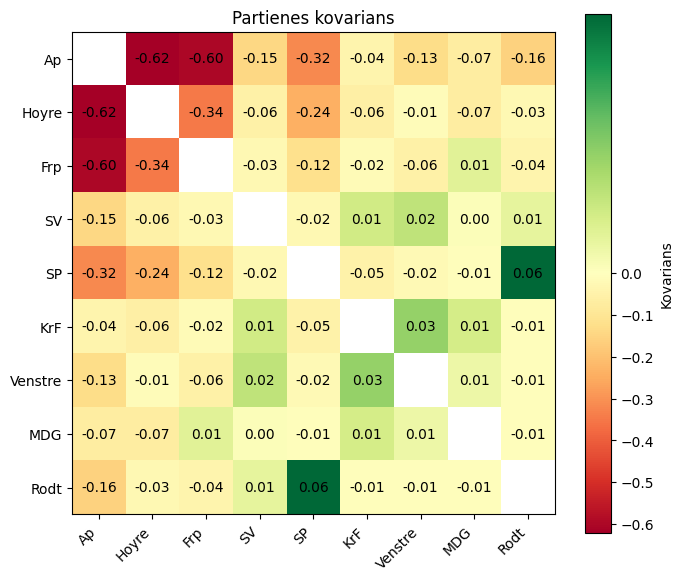

In [224]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Party labels
labels = ['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt']

# Mask diagonal to hide color
W_masked = W.copy()
np.fill_diagonal(W_masked, np.nan)

# Normalize colormap to center at zero
norm = mcolors.TwoSlopeNorm(vmin=np.nanmin(W_masked), vcenter=0, vmax=np.nanmax(W_masked))

plt.figure(figsize=(7, 6))
im = plt.imshow(W_masked, cmap='RdYlGn', norm=norm)
plt.colorbar(im, label='Kovarians')
plt.title('Partienes kovarians')

# Add numerical values for non-diagonal cells
for i in range(W.shape[0]):
    for j in range(W.shape[1]):
        if i != j:
            plt.text(j, i, f"{W[i, j]:.2f}", ha='center', va='center', color='black')

# Set axis ticks and labels
plt.xticks(ticks=np.arange(len(labels)), labels=labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(labels)), labels=labels)

plt.grid(False)
plt.tight_layout()
plt.show()


In [225]:
sample_169['rg'] = sample_169[["Ap", "SV", "SP", "Rodt", "MDG"]].sum(axis=1)

In [226]:
sample_169['bb'] = sample_169[["Hoyre", "Frp", "Venstre", "KrF"]].sum(axis=1)

In [227]:
sample_169

Party,Ap,Hoyre,Frp,SV,SP,KrF,Venstre,MDG,Rodt,Sum_adj,rg,bb
0,52,27,38,12,15,4,4,4,13,169,96,73
1,51,25,39,12,9,8,8,7,10,169,89,80
2,50,30,37,10,9,8,7,7,11,169,87,82
3,46,27,41,12,10,9,7,7,10,169,85,84
4,50,26,38,11,11,9,7,7,10,169,89,80
...,...,...,...,...,...,...,...,...,...,...,...,...
999995,48,29,39,12,10,8,9,3,11,169,84,85
999996,48,27,39,14,10,9,4,4,14,169,90,79
999997,49,25,44,11,11,10,4,4,11,169,86,83
999998,48,26,38,11,13,8,7,7,11,169,90,79


In [228]:
sample_169['r_win'] = (sample_169['bb'] < sample_169['rg'])

In [229]:
sample_169['r_win'].mean()

0.840629

In [230]:
filtered = sample_169[(sample_169['MDG'] < 4) & (sample_169['KrF'] > 4) & (sample_169['Venstre'] > 4)]

# Calculate probability
prob = filtered['r_win'].mean()

print(f"Probability: {prob:.4f}")
print(f"Number of cases: {len(filtered)}")

Probability: 0.6812
Number of cases: 226665


In [231]:
len(sample_169[sample_169['Rodt'] < 8])

91

In [232]:
sample_169['red_green'] = sample_169[["Ap", "SV", "SP", "Rodt", "MDG"]].sum(axis=1)

In [233]:
sample_169['red_green'] = sample_169[["Ap", "SV", "SP", "Rodt", "MDG"]].sum(axis=1)
sample_169['ap_sp'] = sample_169[["Ap", "SP"]].sum(axis=1)
sample_169['ap_sp_sv'] = sample_169[["Ap", "SP", "SV"]].sum(axis=1)
sample_169['ap_sp_sv_r'] = sample_169[["Ap", "SP", "SV", "Rodt"]].sum(axis=1)
sample_169['ap_sp_sv_r_mdg'] = sample_169[["Ap", "SP", "SV", "Rodt", "MDG"]].sum(axis=1)
sample_169['h_frp'] = sample_169[["Hoyre", "Frp"]].sum(axis=1)
sample_169['h_frp_v_krf'] = sample_169[["Hoyre", "Frp", "Venstre", "KrF"]].sum(axis=1)
sample_169['h_frp_v_krf_mdg'] = sample_169[["Hoyre", "Frp", "Venstre", "KrF", "MDG"]].sum(axis=1)

In [234]:
sample_169['red_green_victory'] = sample_169['red_green'] >= 85
sample_169['ap_sp_victory'] = sample_169['ap_sp'] >= 85
sample_169['ap_sp_sv_victory'] = sample_169['ap_sp_sv'] >= 85
sample_169['ap_sp_sv_r'] = sample_169['ap_sp_sv_r'] >= 85
sample_169['ap_sp_sv_r_mdg'] = sample_169['ap_sp_sv_r_mdg'] >= 85
sample_169['h_frp'] = sample_169['h_frp'] >= 85
sample_169['h_frp_v_krf'] = sample_169['h_frp_v_krf'] >= 85
sample_169['h_frp_v_krf_mdg'] = sample_169['h_frp_v_krf_mdg'] >= 85

In [235]:
sample_169['r_avh'] = (sample_169[["Ap", "SP", "SV"]].sum(axis=1) < 85) & (sample_169[["Ap", "SP", "SV", "Rodt"]].sum(axis=1)) >= 85

In [236]:
sample_169['g_avh'] = (sample_169[["Ap", "SP", "SV", "Rodt"]].sum(axis=1) < 85) & (sample_169[["Ap", "SP", "SV", "Rodt", "MDG"]].sum(axis=1)) >= 85

In [237]:
print(sample_169['red_green_victory'].mean())
print(sample_169['ap_sp_victory'].mean())
print(sample_169['ap_sp_sv_victory'].mean())
print(sample_169['ap_sp_sv_r'].mean())
print(sample_169['ap_sp_sv_r_mdg'].mean())
print(sample_169['h_frp'].mean())
print(sample_169['h_frp_v_krf'].mean())
print(sample_169['h_frp_v_krf_mdg'].mean())
print(sample_169['r_avh'].mean())
print(sample_169['g_avh'].mean())

0.840629
0.0
1e-06
0.213231
0.840629
0.0
0.159371
0.786769
0.0
0.0


In [238]:
sample_169.to_csv('sample.csv')

PermissionError: [Errno 13] Permission denied: 'sample.csv'

In [ ]:
len(sample_169['rg'])

In [ ]:
np.round(sample_169['rg'])

In [ ]:

plt.hist(
    sample_169['rg'],
    bins=range(75, sample_169['rg'].max() + 2),
    edgecolor='black',
    color='red'       # Set bar color to red
)
plt.axvline(
    x=84,
    color='black',
    linestyle='--',
    linewidth=2,
    label='grense for fleirtal i stortinget' # Optional label
)
plt.title('Sannsynsfordeling av raudgrøne mandat (OneSixtyNinev2.0 27.08.2025)')
plt.xlabel('Antall mandat')
plt.ylabel('Antall simuleringar')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

In [ ]:
last_actual_value

In [ ]:
last_fact=df_orig[df_orig.index=='2025-08-31'][['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt']]

In [ ]:
last_fact

In [ ]:
last_mandate=pd.DataFrame(columns=last_fact.columns)

In [ ]:
for party in last_fact.columns:
    last_mandate[party]=last_fact[party].apply(calc_mandat)

In [ ]:
last_mandate

In [ ]:
last_mandate['Sum']=last_mandate.sum(axis=1)

In [ ]:
last_mandate

In [ ]:
forecast_df

In [ ]:
forecast_df['Sum']=forecast_df.sum(axis=1)

In [ ]:
forecast_df

In [ ]:
cov_matrix

In [ ]:
forecast

In [ ]:
import numpy as np
from scipy.optimize import minimize

# example: estimates
parties = [c for c in forecast_df.columns if c != "Sum"]
e = forecast_df.loc["2025-09-30", parties].values


# weight matrix (identity for simple case)
W = cov_matrix

def objective(p):
    diff = p - e
    return diff @ W @ diff  # quadratic form

cons = [{'type': 'eq', 'fun': lambda p: np.sum(p) - 100}]
bounds = [(0, None)] * len(e)

res = minimize(objective, e, constraints=cons, bounds=bounds)
p_adj = res.x
print(p_adj)

In [ ]:
p_adj

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# --- Original data ---
data = {
    "Party": ["Ap","Hoyre","Frp","SV","SP","KrF","Venstre","MDG","Rodt","Andre"],
    "Estimate": [26.714087,14.831995,22.153471,6.988594,6.739506,
                 3.640382,4.511437,3.819225,6.402255,4.280916],
    "Lower": [24.346810,12.849953,20.292450,6.242100,5.252677,
              3.075438,3.856005,3.265368,5.684441,3.644205],
    "Upper": [29.081364,16.814037,24.014491,7.735087,8.226335,
              4.205326,5.166869,4.373082,7.120068,4.917626]
}
df = pd.DataFrame(data)

# --- adjustment function ---
def adjust_to_100(x):
    W = np.eye(len(x))  # simple equal weighting

    def objective(p):
        diff = p - x
        return diff @ W @ diff

    cons = [{'type': 'eq', 'fun': lambda p: np.sum(p) - 100}]
    bounds = [(0, None)] * len(x)

    res = minimize(objective, x, constraints=cons, bounds=bounds)
    return res.x

# --- Adjust all three columns ---
df["Estimate_adj"] = adjust_to_100(df["Estimate"].values)
df["Lower_adj"]    = adjust_to_100(df["Lower"].values)
df["Upper_adj"]    = adjust_to_100(df["Upper"].values)

# --- Sanity check sums ---
print("Original sums:", df[["Estimate","Lower","Upper"]].sum())
print("Adjusted sums:", df[["Estimate_adj","Lower_adj","Upper_adj"]].sum())

print(df)


In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Data
df = pd.DataFrame({
    'Party': ['Ap','Hoyre','Frp','SV','SP','KrF','Venstre','MDG','Rodt','Andre'],
    'Estimate': [26.714087,14.831995,22.153471,6.988594,6.739506,3.640382,4.511437,3.819225,6.402255,4.280916],
    'Lower': [24.346810,12.849953,20.292450,6.242100,5.252677,3.075438,3.856005,3.265368,5.684441,3.644205],
    'Upper': [29.081364,16.814037,24.014491,7.735087,8.226335,4.205326,5.166869,4.373082,7.120068,4.917626]
})

# Covariance matrix
W = cov_matrix
W_inv = np.linalg.inv(W)

def adjust_column(orig):
    """Minimize Mahalanobis distance subject to sum=100"""
    def objective(x):
        delta = x - orig
        return delta @ W_inv @ delta
    constraint = {'type': 'eq', 'fun': lambda x: x.sum() - 100}
    res = minimize(objective, orig, constraints=constraint)
    return res.x

# Apply to each column
df['Estimate_adj'] = adjust_column(df['Estimate'].values)
df['Lower_adj'] = adjust_column(df['Lower'].values)
df['Upper_adj'] = adjust_column(df['Upper'].values)

# Check sums
print(df[['Estimate_adj','Lower_adj','Upper_adj']].sum())
print(df)


In [ ]:
df